#  DQN

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://en.wikipedia.org/wiki/Q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car/tree/master
* https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/

## Задачи для совместного разбора

1\. Обсудите основные отличия DQN от классических вариантов Q-learning.

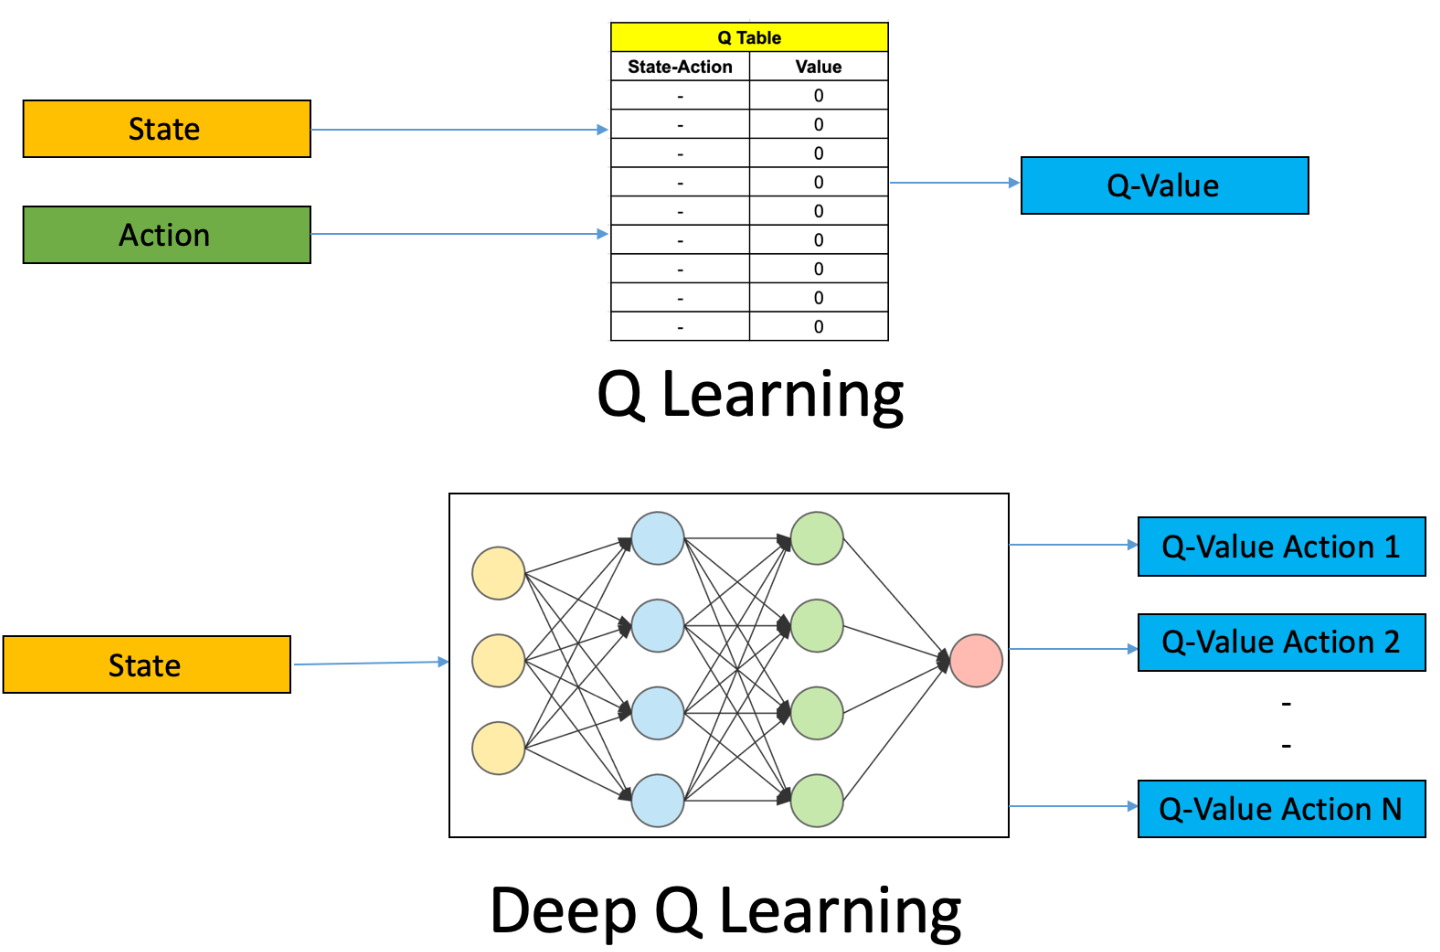

<img src="https://valohai.com/blog/reinforcement-learning-tutorial-part-1-q-learning/image4.png" width="500">
<img src="https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/4.png" width="500">


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите класс `ReplayMemory` для хранения переходов между состояниями.

- [ ] Проверено на семинаре

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

<p class="task" id="2"></p>

2\. Допишите класс `DQN` для моделирования Q-функции.

- [ ] Проверено на семинаре

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

<p class="task" id="3"></p>

3\. Допишите классы `PolicyConfig` для настроек политики агента и `Policy` для реализации политики.

- [ ] Проверено на семинаре

In [ ]:
from dataclasses import dataclass
from IPython.display import clear_output

@dataclass
class PolicyConfig:

    n_observations: int
    n_actions: int
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path: str = "dqn_model.pth"

In [ ]:
class Policy:
    def __init__(self, policy_cfg: PolicyConfig):
        self.device = policy_cfg.device
        self.path = policy_cfg.model_path

        self.policy_network = DQN(policy_cfg.n_observations, policy_cfg.n_actions).to(self.device)
        self.target_network = DQN(policy_cfg.n_observations, policy_cfg.n_actions).to(self.device)

        self.sync_models()
        self.target_network.eval()

    def sync_models(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def get_best_action(self, state: torch.Tensor) -> int:
        self.policy_network.eval()

        with torch.no_grad():
            if state.dim() == 1:
                state = state.unsqueeze(0)

            state = state.to(self.device)
            q_values = self.policy_network(state)
            action = q_values.max(1)[1].item()

        return action

    def save(self):
        torch.save(self.policy_network.state_dict(), self.path)

    def load(self):
        self.policy_network.load_state_dict(torch.load(self.path, map_location=self.device))
        self.sync_models()

<p class="task" id="4"></p>

4\. Напишите функцию `plot_metrics`, которая будет использоваться для визуализации процесса обучения: суммарной награды за каждый эпизод и максимальное значение x-координаты машины за эпизод. Для реализации можете воспользоваться `wandb` или любым другим удобным инструментом.

- [ ] Проверено на семинаре

In [ ]:
def plot_metrics(rewards, max_xs):

    clear_output(wait=True)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(rewards, label='Reward per Episode', color='blue')

    if len(rewards) >= 50:
        moving_avg = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(range(49, len(rewards)), moving_avg, label='Moving Avg (50)', color='red')
    plt.title("Total Reward over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(max_xs, label='Max X Position', color='green')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Goal (0.5)')
    plt.title("Max X Position over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Position X")
    plt.legend()
    plt.grid(True)

    plt.show()

<p class="task" id="5"></p>

5\. Допишите классы `TrainConfig` для настроек обучения и `Trainer` для реализации процесса обучения.

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class TrainConfig:

    batch_size: int = 256
    gamma: float = 0.99
    learning_rate: float = 1e-3

    eps_start: float = 1.0
    eps_end: float = 0.1
    eps_decay: int = 10000

    target_update: int = 20
    memory_capacity: int = 50000
    n_episodes: int = 800

In [ ]:
class Trainer:
    def __init__(self, env: gym.Env, train_config: TrainConfig, policy: Policy):
        self.env = env
        self.cfg = train_config
        self.policy = policy

        self.memory = ReplayMemory(self.cfg.memory_capacity)
        self.optimizer = optim.Adam(self.policy.policy_network.parameters(), lr=self.cfg.learning_rate)
        self.criterion = nn.SmoothL1Loss()
        self.steps_done = 0

    def train(self):
        rewards_history = []
        max_x_history = []

        print("Начинаем обучение с Reward Shaping...")

        for episode in range(self.cfg.n_episodes):
            reward, max_x = self.run_episode()

            rewards_history.append(reward)
            max_x_history.append(max_x)
            if episode % 10 == 0:
                plot_metrics(rewards_history, max_x_history)

            if episode % self.cfg.target_update == 0:
                self.policy.sync_models()

            if max_x >= 0.5:
                self.policy.save()

    def run_episode(self):
        state, _ = self.env.reset()
        total_original_reward = 0
        max_x = -1.2

        done = False
        while not done:
            eps_threshold = self.cfg.eps_end + (self.cfg.eps_start - self.cfg.eps_end) * \
                            math.exp(-1. * self.steps_done / self.cfg.eps_decay)
            self.steps_done += 1

            if random.random() < eps_threshold:
                action = self.env.action_space.sample()
            else:
                action = self.policy.get_best_action(state)

            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            if isinstance(next_state, torch.Tensor):
                pos = next_state[0].item()
            else:
                pos = next_state[0]

            height_bonus = abs(pos - (-0.5))

            modified_reward = reward + (height_bonus * 10)
            if terminated and pos >= 0.5:
                modified_reward += 100.0

            r_tensor = torch.tensor([modified_reward], device=self.policy.device, dtype=torch.float32)
            a_tensor = torch.tensor([[action]], device=self.policy.device)
            is_done = terminated

            self.memory.push(state, a_tensor, next_state, r_tensor, is_done)
            self.generate_batch_and_fit()

            state = next_state
            total_original_reward += reward
            max_x = max(max_x, pos)

        return total_original_reward, max_x

    def generate_batch_and_fit(self):
        if len(self.memory) < self.cfg.batch_size: return

        transitions = self.memory.sample(self.cfg.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.stack(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.stack(batch.next_state)

        non_final_mask = torch.tensor(tuple(map(lambda d: not d, batch.done)),
                                      device=self.policy.device, dtype=torch.bool)

        next_state_values = torch.zeros(self.cfg.batch_size, device=self.policy.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = \
                self.policy.target_network(next_state_batch[non_final_mask]).max(1)[0]

        expected_state_action_values = reward_batch + (next_state_values * self.cfg.gamma)

        self.fit_policy_network(state_batch, action_batch, expected_state_action_values)

    def fit_policy_network(self, states, actions, targets):
        state_action_values = self.policy.policy_network(states).gather(1, actions)
        loss = self.criterion(state_action_values, targets.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy.policy_network.parameters(), 100)
        self.optimizer.step()

<p class="task" id="6"></p>

6\. Настройте модель для управления машиной в окружении `MountainCar-v0`. Для преобразования векторов состояний в тензоры используйте обертку `TransformObservation`. Выведите на экран график с информацией о процессе обучения. При необходимости вставьте скриншоты этих графиков.

- [ ] Проверено на семинаре

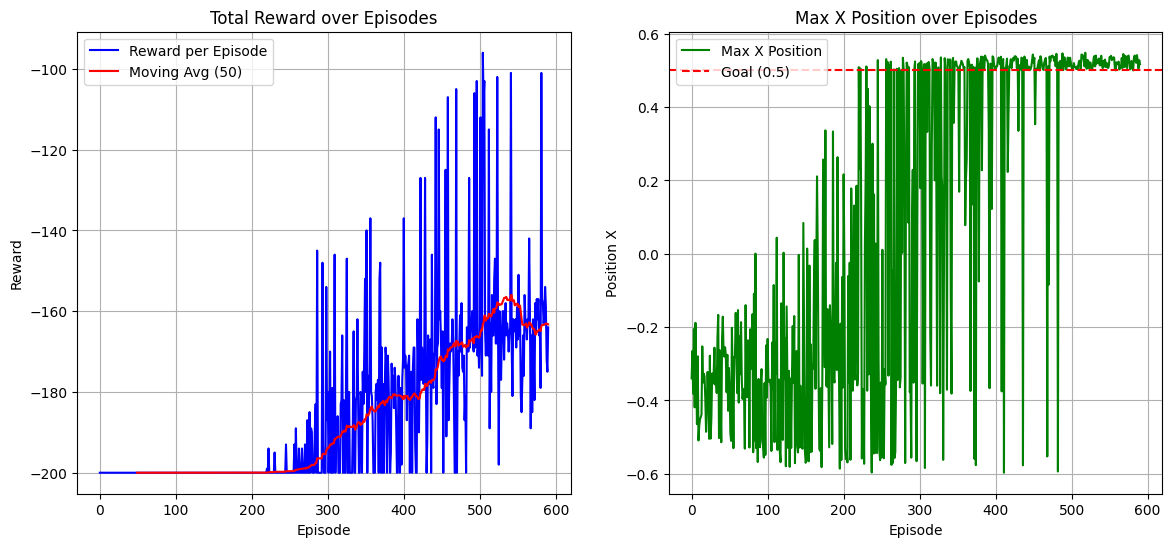

TypeError: 'NoneType' object is not callable

In [ ]:
base_env = gym.make('MountainCar-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = TransformObservation(
    base_env,
    lambda obs: torch.tensor(obs, dtype=torch.float32, device=device),
    base_env.observation_space
)

n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_cfg = PolicyConfig(n_observations=n_states, n_actions=n_actions, device=device)
train_cfg = TrainConfig(n_episodes=600)

dqn_policy = Policy(policy_cfg)
trainer = Trainer(env, train_cfg, dqn_policy)

trainer.train()
env.close()()